In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
os.chdir('/content/drive/MyDrive/A2W')

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression


from xgboost import plot_importance
from xgboost import XGBClassifier

In [5]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

# DNN DAY1 예측

In [13]:
#PLOT의 변수 설정
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [14]:
#최대 출력 칼럼 수 지정
pd.set_option('display.max_columns',1000)

In [15]:
file = tf.keras.utils
raw_df = pd.read_csv("merge_final_real.csv", encoding='utf-8-sig')

In [16]:
raw_df['1day_yn'] = 0.0
raw_df['2day_yn'] = 0.0

In [17]:
# 열을 밀어서 출력, 맨 첫날, 마지막 날의 경우 산사태가 발생하지 않음.
raw_df['1day_yn'][1:-1] = raw_df['landslide'][0:-2]
raw_df['2day_yn'][2:-1] = raw_df['landslide'][0:-3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
neg, pos = np.bincount(raw_df['1day_yn'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 2093790
    Positive: 359 (0.02% of total)



In [19]:
#분석을 위해 음수 값을 가지는 칼럼들을 제외하고 결측치를 0으로 대체한다.
select_df = raw_df[['mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs', 'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN','CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLANT_TYP','SLDPT_TPCD','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD','FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT','1day_yn']]
cleaned_df = select_df.fillna(0)
cleaned_df.info()
cleaned_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093790 entries, 0 to 2093789
Data columns (total 29 columns):
 #   Column      Dtype  
---  ------      -----  
 0   mi10MaxRn   float64
 1   hr1MaxRn    float64
 2   sumRnDur    float64
 3   sumRn       float64
 4   maxInsWs    float64
 5   maxWs       float64
 6   avgWs       float64
 7   minRhm      float64
 8   avgRhm      float64
 9   n99Rn       float64
 10  PRRCK_LARG  int64  
 11  PRRCK_MDDL  int64  
 12  LOCTN_ALTT  float64
 13  LOCTN_GRDN  float64
 14  CLZN_CD     int64  
 15  TPGRP_TPCD  int64  
 16  PRDN_FOM_C  int64  
 17  SLANT_TYP   int64  
 18  SLDPT_TPCD  int64  
 19  SCSTX_CD    int64  
 20  SLTP_CD     int64  
 21  STORUNST    float64
 22  FROR_CD     float64
 23  FRTP_CD     float64
 24  KOFTR_GROU  float64
 25  DMCLS_CD    float64
 26  AGCLS_CD    float64
 27  HEIGHT      float64
 28  1day_yn     float64
dtypes: float64(20), int64(9)
memory usage: 463.3 MB


,mi10MaxRn,hr1MaxRn,sumRnDur,sumRn,maxInsWs,maxWs,avgWs,minRhm,avgRhm,n99Rn,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,HEIGHT,1day_yn
0,0.0,0.0,19.33,28.0,29.4,19.0,11.1,65.0,82.5,5.8,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
1,0.0,0.0,22.83,24.8,14.5,8.5,6.0,65.0,91.5,29.7,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
2,0.0,0.0,12.83,7.5,15.9,10.2,6.5,61.0,80.3,0.3,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
3,0.0,0.0,0.00,0.0,11.2,6.8,3.1,53.0,63.1,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
4,0.0,0.0,7.25,1.8,13.9,6.9,4.1,42.0,61.5,12.3,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0


In [20]:
# 데이터 스플릿, 셔플링
train_df, test_df = train_test_split(cleaned_df, test_size=0.25)
train_df, val_df = train_test_split(train_df, test_size=0.25)

#label(변수들), feature(landslide)를 np array 형태로 변환
train_labels = np.array(train_df.pop('1day_yn'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('1day_yn'))
test_labels = np.array(test_df.pop('1day_yn'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [21]:
# sklearn StandardScaler를 사용하여 입력 기능을 정규화
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (1177756,)
Validation labels shape: (392586,)
Test labels shape: (523448,)
Training features shape: (1177756, 28)
Validation features shape: (392586, 28)
Test features shape: (523448, 28)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


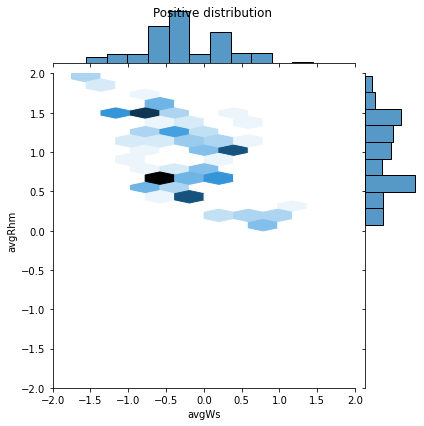

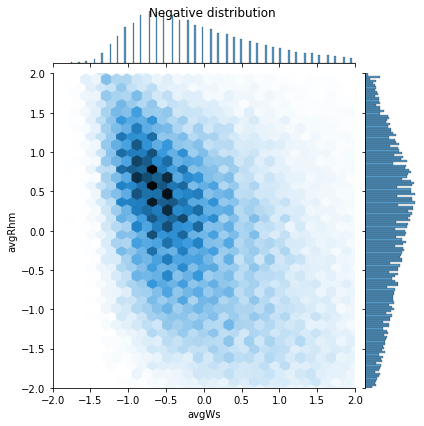

In [22]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['avgWs'], pos_df['avgRhm'],
              kind='hex', xlim=(-2,2), ylim=(-2,2))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['avgWs'], neg_df['avgRhm'],
              kind='hex', xlim=(-2,2), ylim=(-2,2))
_ = plt.suptitle("Negative distribution")

In [23]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential(
      [
      keras.layers.Dense(
          256, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [24]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [25]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7424      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 7,681
Trainable params: 7,681
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
model.predict(train_features[:10])

array([[0.745184  ],
       [0.5752426 ],
       [0.64907473],
       [0.7185538 ],
       [0.6498636 ],
       [0.7595961 ],
       [0.66808176],
       [0.71663415],
       [0.69896114],
       [0.6377602 ]], dtype=float32)

In [27]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.2370


In [28]:
#pos, neg는 위에서 이미 정의함
initial_bias = np.log([pos/neg])
initial_bias

array([-8.67099252])

In [29]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


array([[1.3053417e-04],
       [5.9856684e-05],
       [4.2050466e-05],
       [1.2469292e-04],
       [1.7032027e-04],
       [1.5729666e-04],
       [1.1661430e-04],
       [1.5711784e-04],
       [4.7519803e-04],
       [1.7872453e-04]], dtype=float32)

In [30]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0016


In [31]:
#가중치 비교를 위한 저장
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [32]:
#바이어스 초기화 x 모델
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [33]:
#바이어스 초기화 O 모델
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [34]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

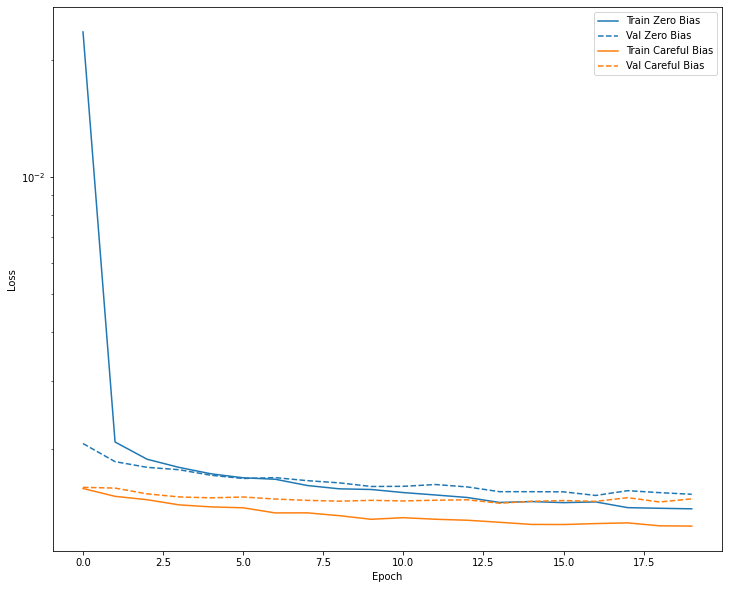

In [35]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [36]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
576/576 [==============================] - 14s 21ms/step - loss: 0.0016 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1570070.0000 - fn: 272.0000 - accuracy: 0.9998 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5144 - val_loss: 0.0016 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 392515.0000 - val_fn: 71.0000 - val_accuracy: 0.9998 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/100
576/576 [==============================] - 12s 20ms/step - loss: 0.0015 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1177555.0000 - fn: 201.0000 - accuracy: 0.9998 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5171 - val_loss: 0.0016 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 392515.0000 - val_fn: 71.0000 - val_accuracy: 0.9998 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5281
Epoch 3/100
576/576 [==============================] - 11s 20ms/step - loss: 0.0015 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1177555.0000 - fn: 201.000

In [39]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


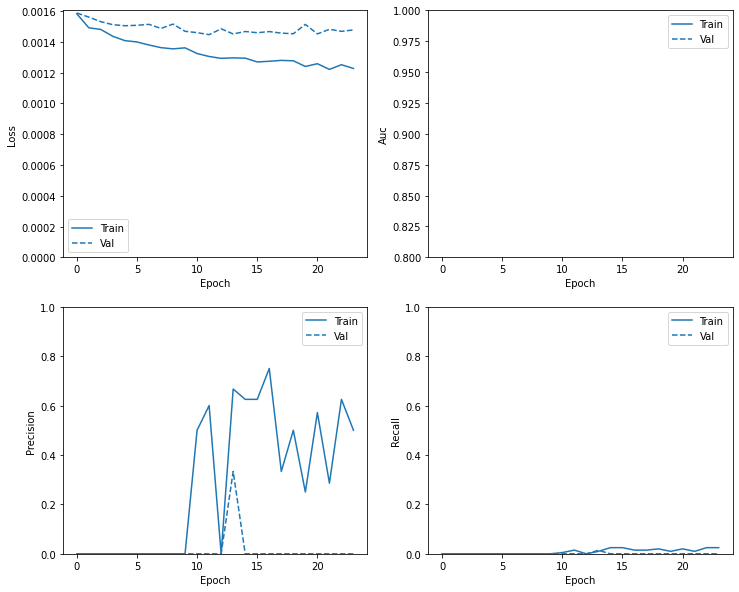

In [40]:
plot_metrics(baseline_history)

In [41]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [42]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0012705721892416477
tp :  2.0
fp :  0.0
tn :  523361.0
fn :  85.0
accuracy :  0.9998376369476318
precision :  1.0
recall :  0.02298850566148758
auc :  0.5910746455192566

Legitimate Transactions Detected (True Negatives):  523361
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  85
Fraudulent Transactions Detected (True Positives):  2
Total Fraudulent Transactions:  87


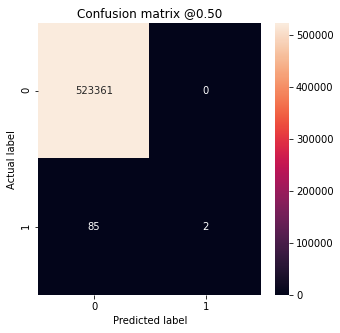

In [43]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [44]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

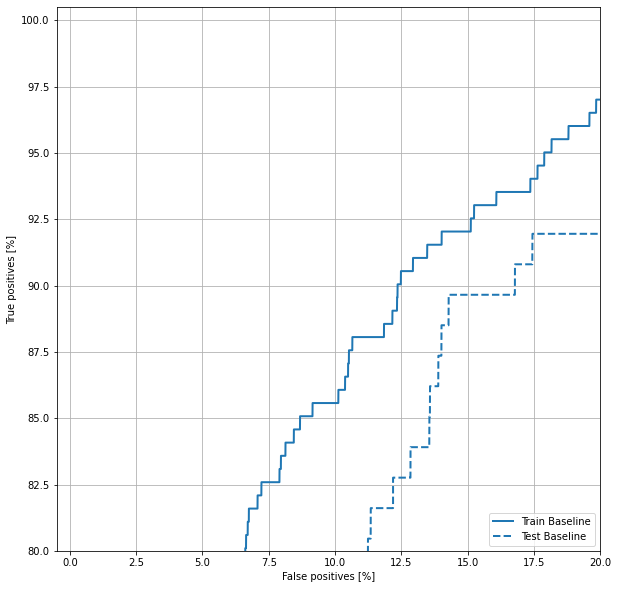

In [45]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [46]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
#neg : 산사태가 발생하지 않을 확률(0)
#pos : 산사태가 발생할 확률(1)
weight_for_0 = (1 / neg)*(total)/1.0 
weight_for_1 = (1 / pos)*(total)/1.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 5832.28


In [47]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
303/576 [==============>...............] - ETA: 4s - loss: 6.5268 - tp: 11.0000 - fp: 14661.0000 - tn: 1129127.0000 - fn: 193.0000 - accuracy: 0.9870 - precision: 7.4973e-04 - recall: 0.0539 - auc: 0.5862

KeyboardInterrupt: ignored

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [48]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [49]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(1177555, 28)

In [50]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(2355110, 28)

In [51]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [52]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 5.          5.         -0.20574581  5.         -1.56241741 -1.48834934
 -1.55468558  2.93432373  1.97024334 -0.11155751  1.60899914  1.38596065
  2.32118279  1.16236157 -0.73761619  0.72528157  1.84664205  0.72256512
  1.99834448 -0.82802689 -0.43297269 -0.02925053  0.32920361  1.05322323
  0.6700739   0.44101698  0.02757217  0.41186122]

Label:  1.0


In [53]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [54]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.51611328125


In [55]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

2045.0

In [56]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
2045/2045 [==============================] - 154s 75ms/step - loss: 0.1743 - tp: 2038218.0000 - fp: 222104.0000 - tn: 3023602.0000 - fn: 54372.0000 - accuracy: 0.9482 - precision: 0.9017 - recall: 0.9740 - auc: 0.9855 - val_loss: 0.0945 - val_tp: 41.0000 - val_fp: 16377.0000 - val_tn: 376138.0000 - val_fn: 30.0000 - val_accuracy: 0.9582 - val_precision: 0.0025 - val_recall: 0.5775 - val_auc: 0.8909
Epoch 2/100
2045/2045 [==============================] - 158s 77ms/step - loss: 0.0707 - tp: 2086113.0000 - fp: 78973.0000 - tn: 2015275.0000 - fn: 7799.0000 - accuracy: 0.9793 - precision: 0.9635 - recall: 0.9963 - auc: 0.9950 - val_loss: 0.0493 - val_tp: 32.0000 - val_fp: 8166.0000 - val_tn: 384349.0000 - val_fn: 39.0000 - val_accuracy: 0.9791 - val_precision: 0.0039 - val_recall: 0.4507 - val_auc: 0.8603
Epoch 3/100
2045/2045 [==============================] - 158s 77ms/step - loss: 0.0436 - tp: 2090953.0000 - fp: 48571.0000 - tn: 2045663.0000 - fn: 2973.0000 - accuracy: 0.987

In [57]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
20/20 [==============================] - 6s 199ms/step - loss: 0.6051 - tp: 13972.0000 - fp: 7539.0000 - tn: 405435.0000 - fn: 6600.0000 - accuracy: 0.9674 - precision: 0.6495 - recall: 0.6792 - auc: 0.9847 - val_loss: 0.5582 - val_tp: 54.0000 - val_fp: 102464.0000 - val_tn: 290051.0000 - val_fn: 17.0000 - val_accuracy: 0.7390 - val_precision: 5.2674e-04 - val_recall: 0.7606 - val_auc: 0.8193
Epoch 2/1000
20/20 [==============================] - 3s 156ms/step - loss: 0.5113 - tp: 15873.0000 - fp: 5458.0000 - tn: 15169.0000 - fn: 4460.0000 - accuracy: 0.7579 - precision: 0.7441 - recall: 0.7807 - auc: 0.8346 - val_loss: 0.5045 - val_tp: 62.0000 - val_fp: 102688.0000 - val_tn: 289827.0000 - val_fn: 9.0000 - val_accuracy: 0.7384 - val_precision: 6.0341e-04 - val_recall: 0.8732 - val_auc: 0.8490
Epoch 3/1000
20/20 [==============================] - 3s 159ms/step - loss: 0.4680 - tp: 17379.0000 - fp: 5379.0000 - tn: 14996.0000 - fn: 3206.0000 - accuracy: 0.7904 - precision: 0.7

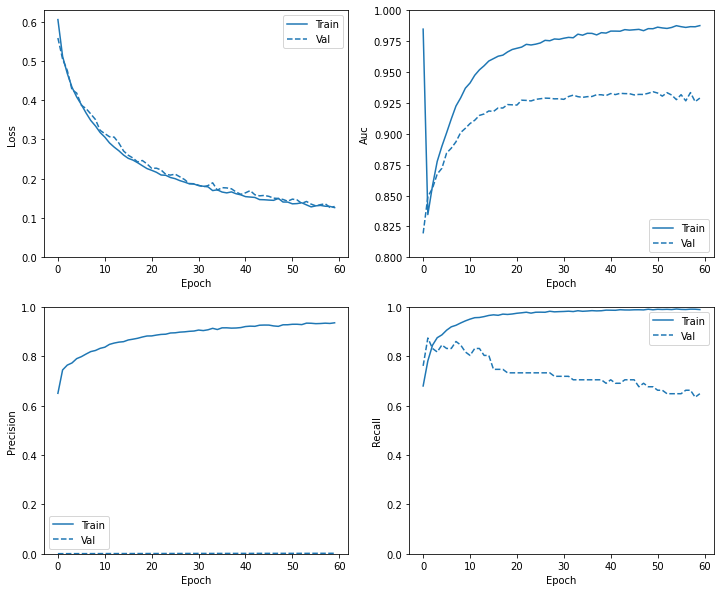

In [58]:
plot_metrics(resampled_history)

NameError: ignored

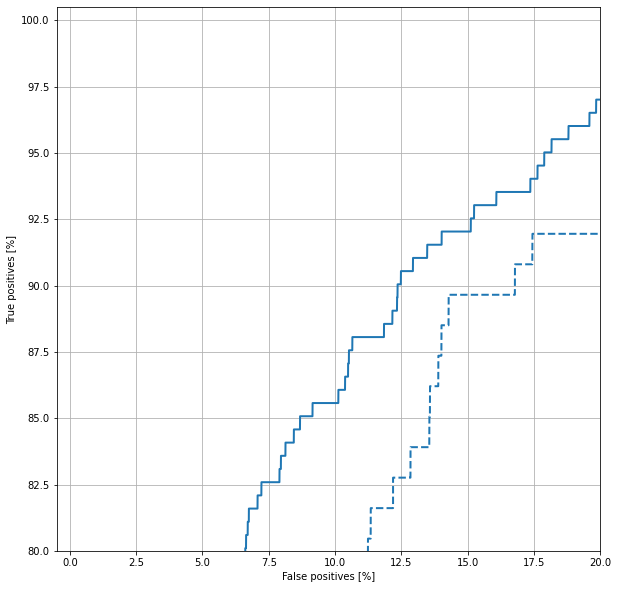

In [59]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

In [60]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.14191603660583496
tp :  62.0
fp :  34529.0
tn :  488832.0
fn :  25.0
accuracy :  0.9339877367019653
precision :  0.0017923737177625299
recall :  0.7126436829566956
auc :  0.9381325840950012

Legitimate Transactions Detected (True Negatives):  488832
Legitimate Transactions Incorrectly Detected (False Positives):  34529
Fraudulent Transactions Missed (False Negatives):  25
Fraudulent Transactions Detected (True Positives):  62
Total Fraudulent Transactions:  87


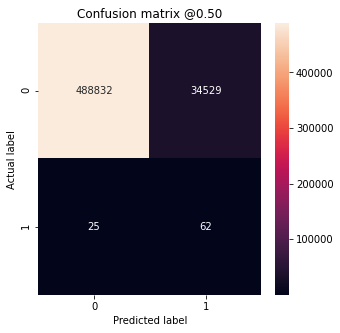

In [61]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

In [62]:
resampled_model.save('resample_model_day1.h5')

# day2 예측

In [63]:
#분석을 위해 음수 값을 가지는 칼럼들을 제외하고 결측치를 0으로 대체한다.
select_df_2 = raw_df[['mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs', 'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN','CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLANT_TYP','SLDPT_TPCD','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD','FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT','2day_yn']]
cleaned_df_2 = select_df_2.fillna(0)
cleaned_df_2.info()
cleaned_df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093790 entries, 0 to 2093789
Data columns (total 29 columns):
 #   Column      Dtype  
---  ------      -----  
 0   mi10MaxRn   float64
 1   hr1MaxRn    float64
 2   sumRnDur    float64
 3   sumRn       float64
 4   maxInsWs    float64
 5   maxWs       float64
 6   avgWs       float64
 7   minRhm      float64
 8   avgRhm      float64
 9   n99Rn       float64
 10  PRRCK_LARG  int64  
 11  PRRCK_MDDL  int64  
 12  LOCTN_ALTT  float64
 13  LOCTN_GRDN  float64
 14  CLZN_CD     int64  
 15  TPGRP_TPCD  int64  
 16  PRDN_FOM_C  int64  
 17  SLANT_TYP   int64  
 18  SLDPT_TPCD  int64  
 19  SCSTX_CD    int64  
 20  SLTP_CD     int64  
 21  STORUNST    float64
 22  FROR_CD     float64
 23  FRTP_CD     float64
 24  KOFTR_GROU  float64
 25  DMCLS_CD    float64
 26  AGCLS_CD    float64
 27  HEIGHT      float64
 28  2day_yn     float64
dtypes: float64(20), int64(9)
memory usage: 463.3 MB


,mi10MaxRn,hr1MaxRn,sumRnDur,sumRn,maxInsWs,maxWs,avgWs,minRhm,avgRhm,n99Rn,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,HEIGHT,2day_yn
0,0.0,0.0,19.33,28.0,29.4,19.0,11.1,65.0,82.5,5.8,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
1,0.0,0.0,22.83,24.8,14.5,8.5,6.0,65.0,91.5,29.7,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
2,0.0,0.0,12.83,7.5,15.9,10.2,6.5,61.0,80.3,0.3,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
3,0.0,0.0,0.00,0.0,11.2,6.8,3.1,53.0,63.1,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
4,0.0,0.0,7.25,1.8,13.9,6.9,4.1,42.0,61.5,12.3,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0


In [65]:
# 데이터 스플릿, 셔플링
train_df_2, test_df_2 = train_test_split(cleaned_df_2, test_size=0.25)
train_df_2, val_df_2 = train_test_split(train_df_2, test_size=0.25)

#label(변수들), feature(landslide)를 np array 형태로 변환
train_labels_2 = np.array(train_df_2.pop('2day_yn'))
bool_train_labels_2 = train_labels_2 != 0
val_labels_2 = np.array(val_df_2.pop('2day_yn'))
test_labels_2 = np.array(test_df_2.pop('2day_yn'))

train_features_2 = np.array(train_df_2)
val_features_2 = np.array(val_df_2)
test_features_2 = np.array(test_df_2)

In [66]:
# sklearn StandardScaler를 사용하여 입력 기능을 정규화
scaler = StandardScaler()
train_features_2 = scaler.fit_transform(train_features_2)

val_features_2 = scaler.transform(val_features_2)
test_features_2 = scaler.transform(test_features_2)

train_features = np.clip(train_features_2, -5, 5)
val_features_2 = np.clip(val_features_2, -5, 5)
test_features_2 = np.clip(test_features_2, -5, 5)


print('Training labels shape:', train_labels_2.shape)
print('Validation labels shape:', val_labels_2.shape)
print('Test labels shape:', test_labels_2.shape)

print('Training features shape:', train_features_2.shape)
print('Validation features shape:', val_features_2.shape)
print('Test features shape:', test_features_2.shape)


Training labels shape: (1177756,)
Validation labels shape: (392586,)
Test labels shape: (523448,)
Training features shape: (1177756, 28)
Validation features shape: (392586, 28)
Test features shape: (523448, 28)


In [67]:
pos_features_2 = train_features_2[bool_train_labels_2]
neg_features_2 = train_features_2[~bool_train_labels_2]

pos_labels_2 = train_labels_2[bool_train_labels_2]
neg_labels_2 = train_labels_2[~bool_train_labels_2]

In [68]:
ids = np.arange(len(pos_features_2))
choices_2 = np.random.choice(ids, len(neg_features_2))

res_pos_features_2 = pos_features_2[choices_2]
res_pos_labels_2 = pos_labels_2[choices_2]

res_pos_features_2.shape

(1177554, 28)

In [69]:
resampled_features_2 = np.concatenate([res_pos_features_2, neg_features_2], axis=0)
resampled_labels_2 = np.concatenate([res_pos_labels_2, neg_labels_2], axis=0)

order_2 = np.arange(len(resampled_labels_2))
np.random.shuffle(order_2)
resampled_features_2 = resampled_features_2[order_2]
resampled_labels_2 = resampled_labels_2[order_2]

resampled_features_2.shape

(2355108, 28)

In [76]:
BUFFER_SIZE = 100000

def make_ds(features_2, labels_2):
  ds = tf.data.Dataset.from_tensor_slices((features_2, labels_2))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds_2 = make_ds(pos_features_2, pos_labels_2)
neg_ds_2 = make_ds(neg_features_2, neg_labels_2)

In [77]:
for features_2, label_2 in pos_ds_2.take(1):
  print("Features:\n", features_2.numpy())
  print()
  print("Label: ", label_2.numpy())

Features:
 [-0.2362071  -0.25558928 -0.20595861 -0.26713192 -0.22969266  0.02705041
 -0.42196602  0.60526225  1.19083518 -0.11227947  0.35102453  0.52811784
 -0.02443848  1.3779779   0.21613098 -0.67270905  1.34748117  0.72305225
  1.99876359  0.71877994  1.59298256 -0.02977335  0.32967628 -0.5558152
 -0.65931404  0.44144034  0.02793179  0.4124871 ]

Label:  1.0


In [78]:
for features_2, label_2 in pos_ds_2.take(1):
  print("Features:\n", features_2.numpy())
  print()
  print("Label: ", label_2.numpy())

Features:
 [-0.2362071  -0.25558928 -0.08674857 -0.26713192  1.54756895 -0.55612867
 -0.52481989  0.90966718  0.98665886  1.29105519  1.61032639  1.38689475
  1.79547745  1.28951987  0.21613098  0.7260911  -0.64557709 -0.56339684
  0.77339259 -0.05570333 -0.4324313  -0.02977335  0.32967628  1.05146894
  0.66766712  0.44144034  0.83841819  0.84420771]

Label:  1.0


In [80]:
resampled_ds_2 = tf.data.experimental.sample_from_datasets([pos_ds_2, neg_ds_2], weights=[0.5, 0.5])
resampled_ds_2 = resampled_ds_2.batch(BATCH_SIZE).prefetch(2)

In [81]:
for features, label in resampled_ds_2.take(1):
  print(label.numpy().mean())

0.48046875


In [82]:
resampled_model_2 = make_model()
resampled_model_2.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer_2 = resampled_model_2.layers[-1] 
output_layer_2.bias.assign([0])

val_ds_2 = tf.data.Dataset.from_tensor_slices((val_features_2, val_labels_2)).cache()
val_ds_2 = val_ds_2.batch(BATCH_SIZE).prefetch(2) 

resampled_2_history = resampled_model_2.fit(
    resampled_ds_2,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds_2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
2045/2045 [==============================] - 206s 99ms/step - loss: 0.1867 - tp: 2019062.0000 - fp: 251672.0000 - tn: 2366315.0000 - fn: 74559.0000 - accuracy: 0.9308 - precision: 0.8892 - recall: 0.9644 - auc: 0.9790 - val_loss: 0.0899 - val_tp: 31.0000 - val_fp: 15746.0000 - val_tn: 376778.0000 - val_fn: 31.0000 - val_accuracy: 0.9598 - val_precision: 0.0020 - val_recall: 0.5000 - val_auc: 0.8711
Epoch 2/100
2045/2045 [==============================] - 154s 75ms/step - loss: 0.0708 - tp: 2083820.0000 - fp: 80491.0000 - tn: 2015518.0000 - fn: 8331.0000 - accuracy: 0.9788 - precision: 0.9628 - recall: 0.9960 - auc: 0.9956 - val_loss: 0.0465 - val_tp: 25.0000 - val_fp: 7791.0000 - val_tn: 384733.0000 - val_fn: 37.0000 - val_accuracy: 0.9801 - val_precision: 0.0032 - val_recall: 0.4032 - val_auc: 0.8263
Epoch 3/100
2045/2045 [==============================] - 156s 76ms/step - loss: 0.0411 - tp: 2092522.0000 - fp: 46621.0000 - tn: 2046599.0000 - fn: 2418.0000 - accuracy: 0.988

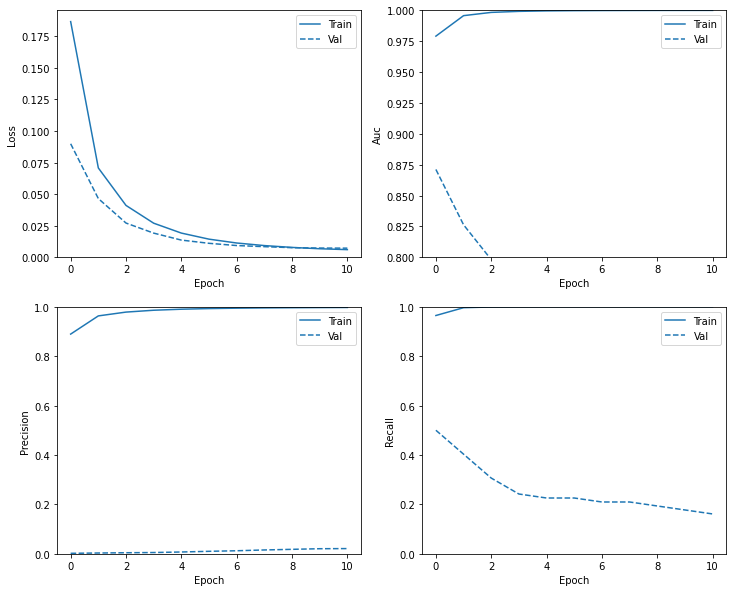

In [83]:
plot_metrics(resampled_2_history)

In [84]:
resampled_model_2 = make_model()
resampled_model_2.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer_2 = resampled_model_2.layers[-1] 
output_layer_2.bias.assign([0])

resampled_2_history = resampled_model_2.fit(
    resampled_ds_2,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds_2))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
20/20 [==============================] - 6s 225ms/step - loss: 0.6221 - tp: 13889.0000 - fp: 7823.0000 - tn: 405291.0000 - fn: 6543.0000 - accuracy: 0.9669 - precision: 0.6397 - recall: 0.6798 - auc: 0.9838 - val_loss: 0.5515 - val_tp: 43.0000 - val_fp: 108311.0000 - val_tn: 284213.0000 - val_fn: 19.0000 - val_accuracy: 0.7241 - val_precision: 3.9685e-04 - val_recall: 0.6935 - val_auc: 0.7863
Epoch 2/1000
20/20 [==============================] - 3s 181ms/step - loss: 0.5203 - tp: 15616.0000 - fp: 5418.0000 - tn: 15178.0000 - fn: 4748.0000 - accuracy: 0.7518 - precision: 0.7424 - recall: 0.7668 - auc: 0.8278 - val_loss: 0.4910 - val_tp: 45.0000 - val_fp: 97984.0000 - val_tn: 294540.0000 - val_fn: 17.0000 - val_accuracy: 0.7504 - val_precision: 4.5905e-04 - val_recall: 0.7258 - val_auc: 0.8333
Epoch 3/1000
20/20 [==============================] - 3s 179ms/step - loss: 0.4685 - tp: 16830.0000 - fp: 5092.0000 - tn: 15267.0000 - fn: 3771.0000 - accuracy: 0.7836 - precision: 0.7

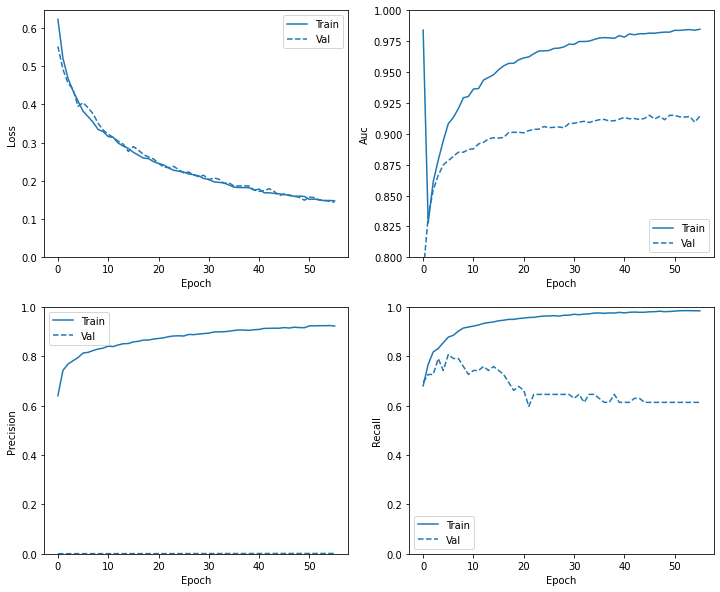

In [86]:
plot_metrics(resampled_2_history)

In [87]:
train_predictions_resampled_2 = resampled_model_2.predict(train_features_2, batch_size=BATCH_SIZE)
test_predictions_resampled_2 = resampled_model_2.predict(test_features_2, batch_size=BATCH_SIZE)

loss :  0.1664278656244278
tp :  51.0
fp :  41500.0
tn :  481853.0
fn :  44.0
accuracy :  0.9206339716911316
precision :  0.0012274072505533695
recall :  0.5368421077728271
auc :  0.8741433024406433

Legitimate Transactions Detected (True Negatives):  481853
Legitimate Transactions Incorrectly Detected (False Positives):  41500
Fraudulent Transactions Missed (False Negatives):  44
Fraudulent Transactions Detected (True Positives):  51
Total Fraudulent Transactions:  95


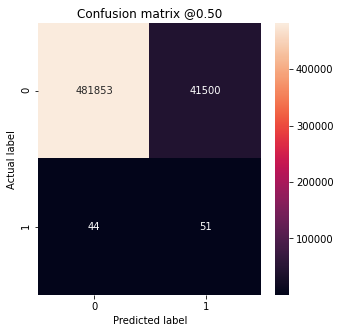

In [88]:
resampled_2_results = resampled_model_2.evaluate(test_features_2, test_labels_2,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model_2.metrics_names, resampled_2_results):
  print(name, ': ', value)
print()

plot_cm(test_labels_2, test_predictions_resampled_2)

# Submission 실행

In [89]:
# Merged_data_file
Merged_2020 = pd.read_csv('/content/drive/MyDrive/A2W/merge_s_h_a20.csv')
# Test 검증 데이터셋
test_input = pd.read_csv('/content/drive/MyDrive/A2W/input.csv', encoding = 'cp949')

In [92]:
# 훈련된 모델로 결과 도출 : day1 함수
def day1_data_test(sgg, umd, date):    
    # sgg 데이터와 umd 데이터, date를 통한 추출
    text = sgg + ' ' + umd
    # specific 자체가 학습 돌린 결과 참고해서 input으로 만들어야 됨
    test_day1 = Merged_2020[Merged_2020['umd2'].str.contains(text.rstrip()) & Merged_2020['tm'].str.contains(date)]
    test_specific_day1 = test_day1[['mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs', 
                                    'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN',
                                    'CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLDPT_TPCD','SLANT_TYP','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD',
                                    'FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT']]
    fillna_test_specific_day1 = test_specific_day1.fillna(0)
    model_pred =  resampled_model.predict(fillna_test_specific_day1.to_numpy(), batch_size=BATCH_SIZE)
    #model_pred = xgb1.predict(fillna_test_specific_day1.to_numpy())
    return model_pred

# 훈련된 모델로 결과 도출 : day2 함수
def day2_data_test(sgg, umd, date):    
    # sgg 데이터와 umd 데이터, date를 통한 추출
    text = sgg + ' ' + umd
    # specific 자체가 학습 돌린 결과 참고해서 input으로 만들어야 됨
    test_day2 = Merged_2020[Merged_2020['umd2'].str.contains(text.rstrip()) & Merged_2020['tm'].str.contains(date)]
    test_specific_day2 = test_day2[['mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs',
                                    'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN',
                                    'CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLDPT_TPCD','SLANT_TYP','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD',
                                    'FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT']]
    fillna_test_specific_day2 = test_specific_day2.fillna(0)
    model_pred = resampled_model_2.predict(fillna_test_specific_day2.to_numpy(),batch_size=BATCH_SIZE)
    #model_pred = xgb2.predict(fillna_test_specific_day2.to_numpy())
    return model_pred

In [93]:
length_test_input = len(test_input.index)

#day_1 data
for index in range(length_test_input):
    if test_input['umd'][index] == "삼거동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상문동"
    elif test_input['umd'][index] == "어곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "강서동"
    elif test_input['umd'][index] == "주진동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "소주동"
    elif test_input['umd'][index] == "시동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "불국동"
    elif test_input['umd'][index] == "덕곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "지좌동"
    elif test_input['umd'][index] == "조와동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상망동"
    else:
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = test_input['umd'][index]
    test_input['1day_yn'][index] = day1_data_test(input_sgg, input_umd, input_date)
        

#day_2 data
for index in range(length_test_input):
    if test_input['umd'][index] == "삼거동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상문동"
    elif test_input['umd'][index] == "어곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "강서동"
    elif test_input['umd'][index] == "주진동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "소주동"
    elif test_input['umd'][index] == "시동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "불국동"
    elif test_input['umd'][index] == "덕곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "지좌동"
    elif test_input['umd'][index] == "조와동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상망동"
    else:
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = test_input['umd'][index]
    test_input['2day_yn'][index] = day2_data_test(input_sgg, input_umd, input_date)


test_input.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,sd,sgg,umd,1day,1day_yn,2day,2day_yn
0,2020-06-10,경상남도,사천시,곤명면,2020-06-11,2.356627e-07,2020-06-12,1.000000e+00
1,2020-06-11,경상남도,사천시,곤명면,2020-06-12,5.372100e-19,2020-06-13,1.000000e+00
2,2020-06-12,경상남도,사천시,곤명면,2020-06-13,0.000000e+00,2020-06-14,1.000000e+00
3,2020-06-10,경상남도,사천시,곤양면,2020-06-11,5.518057e-17,2020-06-12,5.489647e-03
4,2020-06-11,경상남도,사천시,곤양면,2020-06-12,6.924027e-30,2020-06-13,8.331938e-19


In [94]:
test_input["1day_yn"].value_counts()

0.000000e+00    2003
1.000000e+00      94
1.943071e-35       2
2.700788e-34       2
2.287453e-06       2
                ... 
1.444727e-37       1
9.857528e-36       1
5.939110e-22       1
2.288444e-25       1
2.180465e-36       1
Name: 1day_yn, Length: 1276, dtype: int64

In [98]:
test_input["2day_yn"].value_counts()

1.000000e+00    0.440469
0.000000e+00    0.406452
3.468095e-17    0.000880
5.082649e-28    0.000880
3.873147e-10    0.000880
                  ...   
2.735614e-21    0.000293
3.714498e-24    0.000293
1.333575e-06    0.000293
7.840529e-09    0.000293
6.071531e-17    0.000293
Name: 2day_yn, Length: 483, dtype: float64

In [96]:
test_input.to_csv("DNN_over_model.csv", index=False, encoding='cp949')

AttributeError: ignored